# 일반화 성능

## 1.환경준비

### (1) import

In [43]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

### (2) 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)


In [44]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(1000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


## 2.데이터 준비

### (1) 데이터 정리

In [45]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

### (2) 데이터분할1 : x, y 나누기

In [46]:
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [47]:
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

## 3.Random Sampling

* 데이터를 랜덤에서 분할하여 모델링 & 예측을 여러번 반복적으로 수행합니다.


### (1) 아래 셀을 반복 실행해 봅시다.


In [48]:
# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

# DecisionTree 모델링
model = DecisionTreeClassifier(max_depth = 3)
model.fit(x_train, y_train)
pred = model.predict(x_val)
accuracy_score(y_val, pred)

0.68

정분류율은 몇 인가요?  
값이 달라지나요? 값이 달라지는 원인은 무엇인가요?   
값이 달라진다면 모델의 성능을 어떻게 믿을 수 있을까요?  

### (2) 여러번 반복해서 평균을 계산해 봅시다.

In [49]:
# 100번 반복 실행하여 결과를 담아 냅시다.

result = []
for i in range(100):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

    model = DecisionTreeClassifier(max_depth = 3)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    result.append(accuracy_score(y_val, pred))

평균과 표준편차를 구해 봅시다.

In [50]:
np.mean(result), np.std(result)

(0.6785499999999999, 0.032103699163803526)

값의 분포를 살짝 살펴보면

mean: 0.6785499999999999 ,  std: 0.032103699163803526


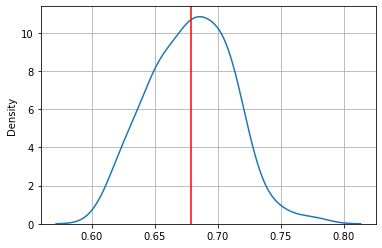

In [51]:
print('mean:', np.mean(result), ',  std:', np.std(result))
sns.kdeplot(result)
plt.axvline(np.mean(result), color = 'r')
plt.grid()
plt.show()

### (3) 실습 : knn 알고리즘으로 실습해 봅시다.

k를 지정하지 말고(default)로 100회 수행한 후 결과를 담고 평균으로 일반화 성능을 얻어 봅시다.

In [52]:
# 100번 반복 실행하여 결과를 담아 냅시다.


## 4.k-fold Cross Validation

계획적으로 분할, 학습, 검증하는 방식을 사용해 봅시다!


### (1) cross_val_score 함수 불러오기

* cross validation 함수를 이용하여 모델을 검증합니다.

In [53]:
# 필요한 패키지, 함수 로딩
from sklearn.model_selection import cross_val_score

### (2) 모델링 및 검증

In [54]:
# 모델 선언 
model = DecisionTreeClassifier(max_depth = 3)

* cross_val_score(모델, x, y, cv)
    * 여기에서 x, y는 train + val 

In [55]:
# train + validation set을 이용하여 학습, 예측, 평가를 한번에. (여기서는 .fit 이 아님!)
dt_result = cross_val_score(model, x, y, cv=10)
print(dt_result)
print(dt_result.mean(), dt_result.std())

[0.66 0.73 0.64 0.68 0.66 0.72 0.63 0.69 0.61 0.73]
0.675 0.040311288741492736


### (3) 실습 : knn알고리즘을 이용하여 k-fold cv 수행
knn알고리즘으로 10-fold cv를 수행해 봅시다.

In [56]:
scaler = MinMaxScaler()

x_s = scaler.fit_transform(x)

In [57]:
knn_result = cross_val_score(estimator=KNeighborsClassifier(), X=x, y=y, cv=10)

print(knn_result)
print(knn_result.mean(), knn_result.std())

[0.57 0.61 0.58 0.64 0.55 0.58 0.62 0.64 0.63 0.56]
0.5979999999999999 0.03218695387886216


## 5.데이터 늘리기(Learning Curve)

### (1) 데이터 준비
데이터의 양을 조금 늘려 놓고 수행하겠습니다.

In [58]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(4000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})

In [59]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (2) learning_curve 함수 불러오기

In [60]:
from sklearn.model_selection import learning_curve

### (3) 데이터 양에 따른 성능 측정

In [61]:
model = DecisionTreeClassifier(max_depth = 3)

In [62]:
x.shape[0]

4000

**learning_curve 함수**
* Input
    * 모델, x, y
    * train_sizes = 순차적으로 학습시킬 데이터 사이즈 리스트(최대 크기 =  전체크기 - (전체크기/cv) )
    * cv = cross validation 설정
* Output
    * tr_size : Input에서 지정한 값리스트(train_sizes)
    * tr_scores : 학습용 데이터에서의 성능
    * val_scores : validation 성능

In [63]:
# 데이터 양이 많을 수록 시간이 오래 걸립니다.
tr_size, tr_scores, val_scores = learning_curve(model, x, y
                                                , train_sizes = range(5, 3200, 10)
                                                , cv = 10)

In [64]:
val_scores[:5]

array([[0.4875, 0.5175, 0.495 , 0.4575, 0.5125, 0.4775, 0.4825, 0.49  ,
        0.5225, 0.4975],
       [0.5375, 0.465 , 0.4925, 0.445 , 0.475 , 0.4725, 0.46  , 0.4775,
        0.4325, 0.4825],
       [0.5175, 0.5825, 0.54  , 0.5075, 0.575 , 0.545 , 0.5475, 0.5875,
        0.58  , 0.545 ],
       [0.5575, 0.5675, 0.5775, 0.545 , 0.5675, 0.5825, 0.565 , 0.54  ,
        0.5975, 0.61  ],
       [0.6075, 0.6075, 0.5425, 0.5275, 0.5375, 0.5925, 0.605 , 0.59  ,
        0.605 , 0.54  ]])

In [65]:
# cv한 결과를 평균으로 집계 합시다.
val_scores_mean = val_scores.mean(axis = 1)
val_scores_std = val_scores.std(axis = 1)

### (4) 성능 평가 : Bias가 줄어드는가?

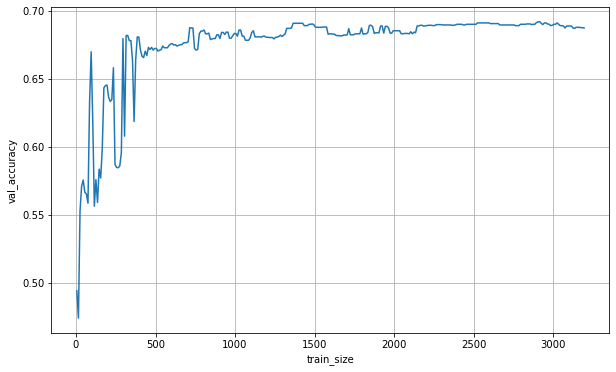

In [66]:
# 이제 그림을 그려봅시다.
# Bias가 줄어드는가? (성능이 향상되는가?)
plt.figure(figsize = (10,6))
plt.plot(tr_size, val_scores_mean)

plt.ylabel('val_accuracy')
plt.xlabel('train_size')
plt.grid()
plt.show()

### (5) 성능 평가 : Variance가 줄어드는가?

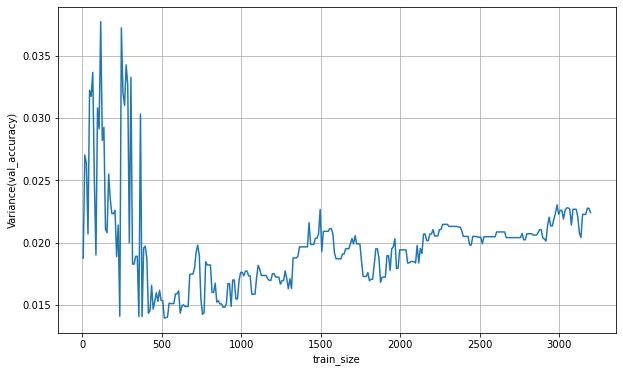

In [67]:
# Variance가 줄어드는가?(성능의 편차가 줄어드는가?)
plt.figure(figsize = (10,6))
plt.plot(tr_size, val_scores_std)

plt.ylabel('Variance(val_accuracy)')
plt.xlabel('train_size')
plt.grid()
plt.show()

In [ ]:
# 어느 정도 데이터이면 학습하는데 충분할까요?
